In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

Found 6652 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names 

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

Tamanho do batch: 32


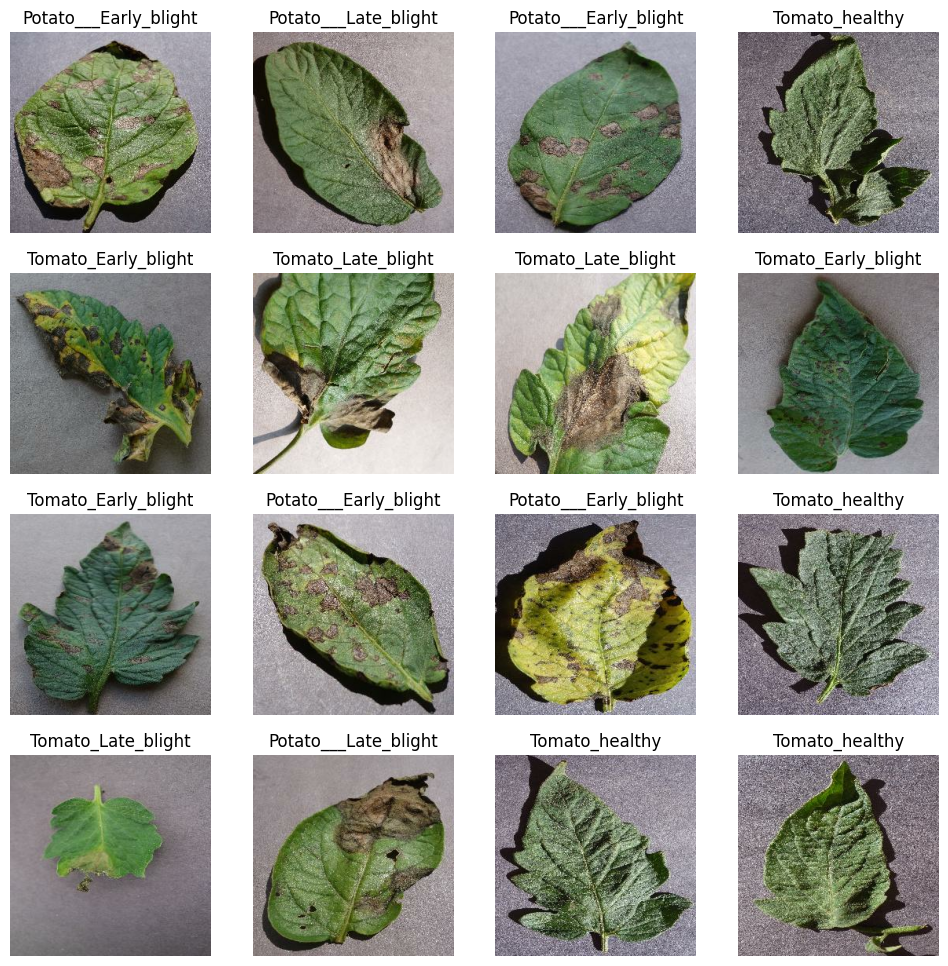

2024-12-22 19:35:56.903936: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for image_batch, label_batch in dataset.take(1):
    print("Tamanho do batch:", image_batch.shape[0])
    plt.figure(figsize=(12, 12))  # Ajusta o tamanho geral do grid
    for i in range(16):  # Ajusta para 16 imagens
        ax = plt.subplot(4, 4, i + 1)  # 4 linhas e 4 colunas
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])  # Atualiza com as novas classes
        plt.axis("off")
    plt.show()

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)



166

In [10]:
len(val_ds)

20

In [11]:
len(test_ds)

22

In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/Users/raulmota/Desktop/LeafSense/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 117s 675ms/step - accuracy: 0.2501 - loss: 1.6781 - val_accuracy: 0.3172 - val_loss: 1.5760
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 113s 666ms/step - accuracy: 0.3705 - loss: 1.4897 - val_accuracy: 0.4843 - val_loss: 1.2890
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 120s 704ms/step - accuracy: 0.5387 - loss: 1.1575 - val_accuracy: 0.6219 - val_loss: 0.9116
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 112s 660ms/step - accuracy: 0.6621 - loss: 0.8160 - val_accuracy: 0.6297 - val_loss: 1.3433
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 111s 658ms/step - accuracy: 0.7194 - loss: 0.7017 - val_accuracy: 0.6344 - val_loss: 1.3698
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 109s 645ms/step - accuracy: 0.7595 - loss: 0.5959 - val_accuracy: 0.6281 - val_loss: 1.3166
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 116s 685ms/step - accuracy: 0.7497 - loss: 0.6275 - val_accuracy: 0.7078 - val_loss: 0.8920
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 114s 673ms/step - accuracy: 0.8000 -

In [20]:
scores = model.evaluate(test_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.9324 - loss: 0.2658


In [21]:
history

In [22]:
model_version = 1

In [23]:
import os

# Define the model directory
model_dir = "../models/"

# Count the number of existing models in the directory
model_count = len([name for name in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, name))])

# Save the model with the new version count
model.save(f"{model_dir}{model_count + 1}.keras")